<a href="https://colab.research.google.com/github/renukarenuuu/FMML_COURSE_ASSIGNMENT/blob/main/Lab3_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data augmentation

FMML Module 1, Lab 3<br>
 Module Coordinator: Thrupthi Ann John thrupthi.ann@research.iiit.ac.in <br>
 Release date: 18 October 2021 <br>

 In this lab, we will see how augmentation of data samples help in improving the machine learning performance

In [ ]:
import math

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp
from scipy.ndimage import zoom

import plotly.express as px
import pandas as pd

# set randomseed
rng = np.random.default_rng(seed=42)

Augmentation is useful when we have less training data available. Augmentation allows us to 'create' a larger dataset programatically.

For this lab we will use a subset of MNIST that is very small, to better understand the effect of augmentation.

In [ ]:
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X/255
test_X = test_X/255

train_X = train_X[::1200,:,:].copy() # subsample. Otherwise it will take too long!
train_y = train_y[::1200].copy() # do the same to the labels


In [ ]:
train_X.shape

(50, 28, 28)

In [ ]:
type(train_X)

numpy.ndarray

Let us borrow a few functions from the previous labs:

In [ ]:
def NN1(traindata: np.ndarray, trainlabel: np.ndarray, query: np.ndarray) -> np.ndarray:
  """
    Predicting the label for one sample using nearest neighbor
  """
  diff  = traindata - query  # find the difference between features. Numpy automatically takes care of the size here
  sq = diff*diff # square the differences
  dist = sq.sum(1) # add up the squares
  label = trainlabel[np.argmin(dist)] # our predicted label is the label of the training data which has the least distance from the query
  return label

def NN(traindata: np.ndarray, trainlabel: np.ndarray, testdata: np.ndarray)-> np.ndarray:
  """
    Predicting the label for set of samples in testdata using nearest neighbor
  """
  # we will run nearest neighbour for each sample in the test data
  # and collect the predicted classes in an array using list comprehension
  traindata = traindata.reshape(-1, 28*28)
  testdata = testdata.reshape(-1,28*28)
  predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
  return predlabel

def Accuracy(gtlabel: np.ndarray, predlabel: np.ndarray) -> float:
  """
    Calculating the accuracy - Total number of samples correctly predicted
  """
  assert len(gtlabel)==len(predlabel), "Length of the groundtruth labels and predicted labels should be the same"
  correct = (gtlabel==predlabel).sum() # count the number of times the groundtruth label is equal to the predicted label.
  return correct/len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time.<br>

Let us check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [ ]:
testpred = NN(train_X, train_y, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))

Baseline accuracy without augmentation is  0.6472


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits.

### Augmentation 1: rotation

Let us try rotating the image a little. We will use skimage library for this.

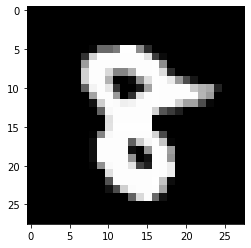

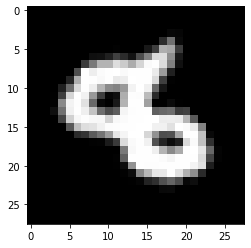

In [ ]:
plt.imshow(train_X[2], cmap='gray')
plt.show()
plt.imshow(rotate(train_X[2],45), cmap='gray')

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [ ]:
def augRotate(sample: np.ndarray, angleconstraint: int) -> np.ndarray:
  """
    Creating augmented sample by rotaion of image
  """
  if angleconstraint == 0:
    return sample
  if len(sample.shape) == 2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5) * angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(sample[ii], angle[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

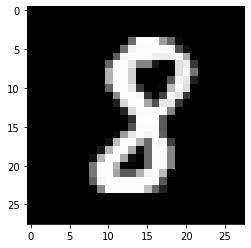

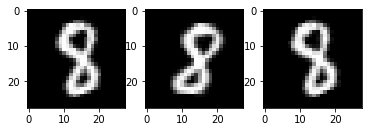

In [ ]:
sample = train_X[20]
angleconstraint = 70
# show the original image
plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show an augmented image
plt.subplot(1,3,2)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show another augmented image from the same sample
plt.subplot(1,3,3)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # one more image from the same sample

Let us augment the whole dataset and see if this improves the test accuracy

In [ ]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

# augment
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print('Accuracy after rotation augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.6616


The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint.

In [ ]:
angleconstraints = [0,10,20,30,40,50,60,70,80,90] # the values we want to test
accuracies = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here

for ii in range(len(angleconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after rotation augmentation constrained by ',angleconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after rotation augmentation constrained by  0  is  0.6472
Accuracy after rotation augmentation constrained by  10  is  0.6732
Accuracy after rotation augmentation constrained by  20  is  0.6862
Accuracy after rotation augmentation constrained by  30  is  0.679
Accuracy after rotation augmentation constrained by  40  is  0.6733
Accuracy after rotation augmentation constrained by  50  is  0.6737
Accuracy after rotation augmentation constrained by  60  is  0.6604
Accuracy after rotation augmentation constrained by  70  is  0.6627
Accuracy after rotation augmentation constrained by  80  is  0.6498
Accuracy after rotation augmentation constrained by  90  is  0.6665


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

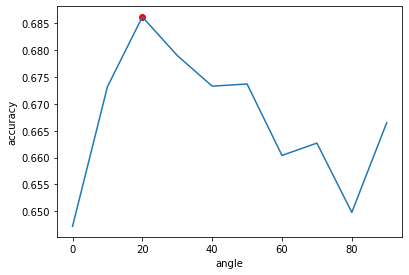

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c='red')

Let us try one more augmentation: shear. Here is what this looks like:

In [ ]:
def shear(sample: np.ndarray, amount: float) -> np.ndarray:
  """
    Produce shear in image.
    This fuction re-centers the image produced before returning
  """
  tform = AffineTransform(shear = amount) # create the shear transform
  img = warp(sample, tform) # apply the shear
  # this makes the digit off-center. Since all the images in the test set are centralized, we will do the same here
  col = img.sum(0).nonzero()[0]
  row = img.sum(1).nonzero()[0]
  if len(col)>0 and len(row)>0:
    xshift = int(sample.shape[0]/2 - (row[0]+row[-1])/2)
    yshift = int(sample.shape[1]/2 - (col[0]+col[-1])/2)
    img = np.roll(img, shift=(xshift, yshift), axis=(0, 1))
  return img

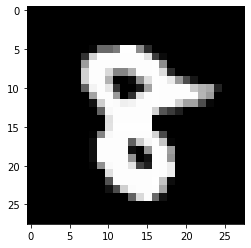

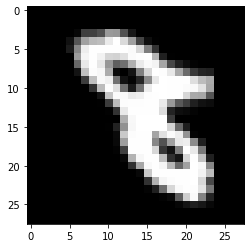

In [ ]:
sample = train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()

# apply shear
plt.imshow(shear(sample, 0.4), cmap='gray')

Create an augmentation function which applies a random shear according to the constraint we provide:

In [ ]:
def augShear(sample: np.ndarray, shearconstraint: float) -> np.ndarray:
  """
   Augmentation of all samples using shear function
  """
  if shearconstraint == 0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = shear(sample[ii], amt[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [ ]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0] # the values we want to test
accuracies = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here

for ii in range(len(shearconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augShear(train_X, shearconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after shear augmentation constrained by ',shearconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after shear augmentation constrained by  0  is  0.6472
Accuracy after shear augmentation constrained by  0.2  is  0.6235
Accuracy after shear augmentation constrained by  0.4  is  0.6395
Accuracy after shear augmentation constrained by  0.6  is  0.6515
Accuracy after shear augmentation constrained by  0.8  is  0.653
Accuracy after shear augmentation constrained by  1.0  is  0.6402
Accuracy after shear augmentation constrained by  1.2  is  0.6345
Accuracy after shear augmentation constrained by  1.4  is  0.6206
Accuracy after shear augmentation constrained by  1.6  is  0.6102
Accuracy after shear augmentation constrained by  1.8  is  0.6152
Accuracy after shear augmentation constrained by  2.0  is  0.6177


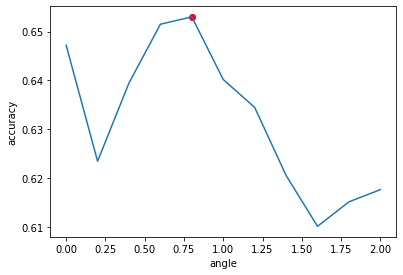

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c='red')

We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [ ]:
def augRotateShear(sample: np.ndarray, angleconstraint: int, shearconstraint: float) -> np.ndarray:
  """
    Augmention of image - Shear then Rotate
  """
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(shear(sample[ii], amt[ii]), angle[ii]) # first apply shear, then rotate
  return np.squeeze(nsample) # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

In [ ]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6] # the values we want to test
angleconstraints = [0,10,20,30,40,50,60] # the values we want to test
hyp = cartesian((shearconstraints, angleconstraints)) # cartesian product of both

accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here

for ii in range(len(hyp)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation shear:',hyp[ii][0], 'angle:',hyp[ii][1], ' is ', accuracies[ii], flush=True)

Accuracy after augmentation shear: 0.0 angle: 0.0  is  0.6332
Accuracy after augmentation shear: 0.0 angle: 10.0  is  0.6037
Accuracy after augmentation shear: 0.0 angle: 20.0  is  0.5962
Accuracy after augmentation shear: 0.0 angle: 30.0  is  0.6083
Accuracy after augmentation shear: 0.0 angle: 40.0  is  0.6204
Accuracy after augmentation shear: 0.0 angle: 50.0  is  0.5981
Accuracy after augmentation shear: 0.0 angle: 60.0  is  0.5926
Accuracy after augmentation shear: 0.2 angle: 0.0  is  0.6336
Accuracy after augmentation shear: 0.2 angle: 10.0  is  0.579
Accuracy after augmentation shear: 0.2 angle: 20.0  is  0.6098
Accuracy after augmentation shear: 0.2 angle: 30.0  is  0.6197
Accuracy after augmentation shear: 0.2 angle: 40.0  is  0.6025
Accuracy after augmentation shear: 0.2 angle: 50.0  is  0.6021
Accuracy after augmentation shear: 0.2 angle: 60.0  is  0.6139
Accuracy after augmentation shear: 0.4 angle: 0.0  is  0.6339
Accuracy after augmentation shear: 0.4 angle: 10.0  is  0.6

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

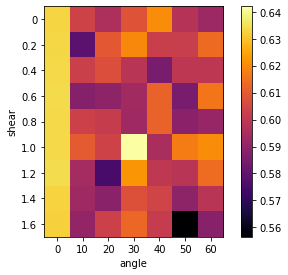

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
im = ax.imshow(accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap='inferno')
ax.set_xlabel('angle')
ax.set_ylabel('shear')
ax.set_xticks(np.arange(len(angleconstraints)));
ax.set_xticklabels(angleconstraints);
ax.set_yticks(np.arange(len(shearconstraints)));
ax.set_yticklabels(shearconstraints);
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them.
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

### Solution

1. When we did the augmentation individually, best angle constraint that I got was 20 and shear constraint was 0.6 When we combined shear and rotation best parameters were 30 for angle and 1.0 for the shear

2. We can do an experiment and test the hypothesis.

In [ ]:
"""
  Here we keep on concatenating the dataset produced for each angle constraint
"""

angleconstraints = [0,10,20,30,40,50,60,70,80,90] # the values we want to test
accuracies = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here
accuracies_train = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here

augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y

for ii in range(len(angleconstraints)):
  # create the augmented dataset
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  trainpred = NN(augdata, auglabel, train_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  accuracies_train[ii] = Accuracy(train_y, trainpred)
  print('Accuracy after rotation augmentation constrained till ',angleconstraints[ii], ' is ', accuracies[ii], 'and train accuracy is', accuracies_train[ii], flush=True)

Accuracy after rotation augmentation constrained till  0  is  0.6472 and train accuracy is 1.0
Accuracy after rotation augmentation constrained till  10  is  0.6705 and train accuracy is 1.0
Accuracy after rotation augmentation constrained till  20  is  0.6769 and train accuracy is 1.0
Accuracy after rotation augmentation constrained till  30  is  0.683 and train accuracy is 1.0
Accuracy after rotation augmentation constrained till  40  is  0.6804 and train accuracy is 1.0
Accuracy after rotation augmentation constrained till  50  is  0.6792 and train accuracy is 1.0
Accuracy after rotation augmentation constrained till  60  is  0.6864 and train accuracy is 1.0
Accuracy after rotation augmentation constrained till  70  is  0.6815 and train accuracy is 1.0
Accuracy after rotation augmentation constrained till  80  is  0.6788 and train accuracy is 1.0
Accuracy after rotation augmentation constrained till  90  is  0.678 and train accuracy is 1.0


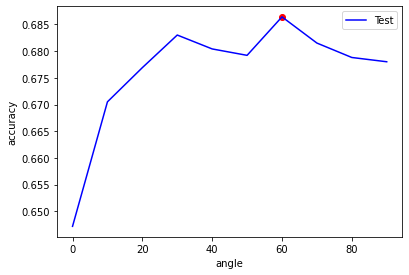

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies, label="Test", color="blue")
# ax.plot(angleconstraints, accuracies_train, label="Train", color="green")
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c='red')

# maxind = np.argmax(accuracies_train)
# plt.scatter(angleconstraints[maxind], accuracies[maxind], c='red')

plt.legend()
plt.show()

It seems that too many augmentation does not create much improvement. Normally too many augmentation can lead to over-fitting of the model.

3. We can test the model by adding scaling and and clipping to the original size.

Here we cannot flip image because, flipping a number doesn't make a number

In [ ]:
def clipped_zoom(img: np.ndarray, zoom_factor: float) -> np.ndarray:
    """
      This function zooms/scales the image and retains the image dimension
    """
    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

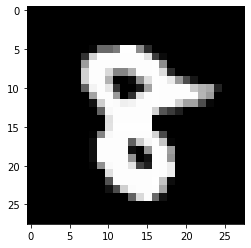

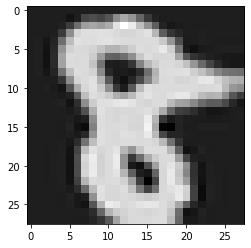

In [ ]:
sample = train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()

# apply shear
plt.imshow(clipped_zoom(sample, 1.4), cmap='gray')

In [ ]:
zoom_factors = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 2.0] # the values we want to test
accuracies = np.zeros(len(zoom_factors), dtype=np.float) # we will save the values here

for ii in range(len(zoom_factors)):
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  # create the augmented dataset
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, zoom_factors[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after rotation augmentation constrained by ',zoom_factors[ii], ' is ', accuracies[ii], flush=True)

Accuracy after rotation augmentation constrained by  0.5  is  0.648
Accuracy after rotation augmentation constrained by  0.6  is  0.6511
Accuracy after rotation augmentation constrained by  0.7  is  0.6495
Accuracy after rotation augmentation constrained by  0.8  is  0.6511
Accuracy after rotation augmentation constrained by  0.9  is  0.6497
Accuracy after rotation augmentation constrained by  1.0  is  0.653
Accuracy after rotation augmentation constrained by  1.1  is  0.6494
Accuracy after rotation augmentation constrained by  1.2  is  0.6522
Accuracy after rotation augmentation constrained by  1.3  is  0.652
Accuracy after rotation augmentation constrained by  1.4  is  0.6539
Accuracy after rotation augmentation constrained by  1.5  is  0.6539
Accuracy after rotation augmentation constrained by  1.6  is  0.6522
Accuracy after rotation augmentation constrained by  1.7  is  0.6527
Accuracy after rotation augmentation constrained by  1.8  is  0.6531
Accuracy after rotation augmentation 

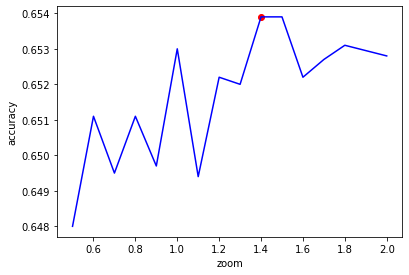

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(zoom_factors, accuracies, label="Test", color="blue")
ax.set_xlabel('zoom')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(zoom_factors[maxind], accuracies[maxind], c='red')
plt.show()

We can see that scaling has a positive impact on accuracy. Best zoom/scale factor is 1.4

4. Testing out on different combination of parameters

In [ ]:
def augZoomRotateShear(sample: np.ndarray, angleconstraint: int, shearconstraint: float, zoom_factor: float) -> np.ndarray:
  """
    Augmention of image - Shear then Rotate
  """
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = clipped_zoom(rotate(shear(sample[ii], amt[ii]), angle[ii]), zoom_factor=zoom_factor) # first apply shear, then rotate, then zoom
  return np.squeeze(nsample) # take care if the input had only one sample.

In [ ]:
shearconstraints = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6] # the values we want to test
angleconstraints = [0, 10, 20, 30, 40, 50, 60] # the values we want to test
zoom_factors = [1.5, 1.6, 1.7, 1.8, 2.0] # the values we want to test

hyp = cartesian((shearconstraints, angleconstraints, zoom_factors)) # cartesian product of both

accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here

for ii in range(len(hyp)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate(
        (augdata, augZoomRotateShear(train_X, hyp[ii][0], hyp[ii][1], hyp[ii][2]))
      ) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation shear:',hyp[ii][0], 'angle:',hyp[ii][1], 'zoom:', hyp[ii][2],' is ', accuracies[ii], flush=True)

Accuracy after augmentation shear: 0.0 angle: 0.0 zoom: 1.5  is  0.6471
Accuracy after augmentation shear: 0.0 angle: 0.0 zoom: 1.6  is  0.6473
Accuracy after augmentation shear: 0.0 angle: 0.0 zoom: 1.7  is  0.6369
Accuracy after augmentation shear: 0.0 angle: 0.0 zoom: 1.8  is  0.6461
Accuracy after augmentation shear: 0.0 angle: 0.0 zoom: 2.0  is  0.6471
Accuracy after augmentation shear: 0.0 angle: 10.0 zoom: 1.5  is  0.6074
Accuracy after augmentation shear: 0.0 angle: 10.0 zoom: 1.6  is  0.6053
Accuracy after augmentation shear: 0.0 angle: 10.0 zoom: 1.7  is  0.6246
Accuracy after augmentation shear: 0.0 angle: 10.0 zoom: 1.8  is  0.6093
Accuracy after augmentation shear: 0.0 angle: 10.0 zoom: 2.0  is  0.6112
Accuracy after augmentation shear: 0.0 angle: 20.0 zoom: 1.5  is  0.5991
Accuracy after augmentation shear: 0.0 angle: 20.0 zoom: 1.6  is  0.6106
Accuracy after augmentation shear: 0.0 angle: 20.0 zoom: 1.7  is  0.633
Accuracy after augmentation shear: 0.0 angle: 20.0 zoom: 

In [ ]:
acc = np.expand_dims(accuracies, 1)
acc = np.hstack((hyp, acc))

In [ ]:
df = pd.DataFrame(acc, columns =['Shear', 'Angle', 'Zoom', 'Accuracy'])
df.head()
fig = px.scatter_3d(df, x='Shear', y='Angle', z='Zoom', color='Accuracy', opacity=0.8)
fig.show()



In [ ]:
# import pickle as plk


In [ ]:
# with open('combination.plk', 'wb') as f:
#   plk.dump(acc, f)

**It seems that angle 0, shear 1.6, and zoom factor 2 seems to be a good choice for augmentation.**

Next we will see what percent of training dataset is needed to have more than 50% accuracy

In [ ]:
train_percent = np.linspace(0.1, 1, 50)
total_train_samples = train_X.shape[0]

train_acc = np.zeros(len(train_percent), dtype=np.float) # we will save the values here

for i in train_percent:
  till_idx = int(total_train_samples * i)
  augdata = train_X[:till_idx] # we include the original images also in the augmented dataset
  auglabel = train_y[:till_idx]
  for jj in range(naugmentations):
    augdata = np.concatenate(
        (augdata, augZoomRotateShear(train_X, angleconstraint=0, shearconstraint=1.6, zoom_factor=2))
      ) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  train_acc[ii] = Accuracy(test_y, testpred)
  print('Accuracy after taking', int(i*100), '% training samples', train_acc[ii], flush=True)


  if train_acc[ii] > 0.50:
    break

Accuracy after taking 10 % training samples 0.2689
Accuracy after taking 11 % training samples 0.2635
Accuracy after taking 13 % training samples 0.2707
Accuracy after taking 15 % training samples 0.342
Accuracy after taking 17 % training samples 0.3484
Accuracy after taking 19 % training samples 0.379
Accuracy after taking 21 % training samples 0.3937
Accuracy after taking 22 % training samples 0.4029
Accuracy after taking 24 % training samples 0.4158
Accuracy after taking 26 % training samples 0.4321
Accuracy after taking 28 % training samples 0.4643
Accuracy after taking 30 % training samples 0.4791
Accuracy after taking 32 % training samples 0.4857
Accuracy after taking 33 % training samples 0.4823
Accuracy after taking 35 % training samples 0.5119


**We see that aleast 35% of dataset with augmentation is required to get accuracy above 50%**